<a href="https://colab.research.google.com/github/Salvoaf/BreastCancerClassification/blob/main/1.%20AnalyzeDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download dataset

In [ ]:
from google.colab import files
files.upload()

In [14]:
!pip install kaggle

In [15]:
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

In [16]:
!cp kaggle.json ~/.kaggle/

In [17]:
!chmod 600 ~/.kaggle/kaggle.json

In [20]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.08G/3.10G [00:19<00:00, 180MB/s]
100% 3.10G/3.10G [00:20<00:00, 166MB/s]


In [ ]:
!unzip breast-histopathology-images.zip

#Let's investigate the structure of the dataset

**Loading packages and setting**

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight


from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm

In [3]:
run_training = False
retrain = False
find_learning_rate = False

**Exploring the data structure**

**How many patients do we have?**

In [4]:
base_path = "../content/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)


279

**How many patches do we have in total?**

In [5]:
total_patches = 0
for patches_each_patient in folder:
  path_patient = base_path +"/"+ patches_each_patient  #"../content/IDC_regular_ps50_idx5/id_patient"
  classes = listdir(path_patient)
  for c in classes:
    path_patient_class = path_patient +"/"+ c   #"../content/IDC_regular_ps50_idx5/id_patient/class0-1"
    total_patches = total_patches + len(listdir(path_patient_class))

  


In [6]:
print(f"Total patches: {total_patches}")

Total patches: 277524


**Storing the image_path, patient_id and the target**

In [7]:
data = pd.DataFrame(index=np.arange(0, total_patches), columns=["patient_id", "path", "target"])
k = 0
for patches_each_patient in folder:
  path_patient = base_path + patches_each_patient  #"../content/IDC_regular_ps50_idx5/id_patient"
  classes = listdir(path_patient)
  for c in classes:
    path_patient_class = path_patient +"/"+ c   #"../content/IDC_regular_ps50_idx5/id_patient/class0-1"
    list_patches = listdir(path_patient_class)
    for name_patch in list_patches:
      data.iloc[k]["path"] = path_patient_class + name_patch
      data.iloc[k]["target"] = c
      data.iloc[k]["patient_id"] = patches_each_patient
      k += 1

data.head()


,patient_id,path,target
0,12824,../content/IDC_regular_ps50_idx5/12824/012824_...,0
1,12824,../content/IDC_regular_ps50_idx5/12824/012824_...,0
2,12824,../content/IDC_regular_ps50_idx5/12824/012824_...,0
3,12824,../content/IDC_regular_ps50_idx5/12824/012824_...,0
4,12824,../content/IDC_regular_ps50_idx5/12824/012824_...,0


In [8]:
data.shape

(277524, 3)

#Let's analyze what we have extracted

In [28]:
#Calculating the percentage of IDC present in each image
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").size() #totale patches di singolo target/ totale patches di entrambi i target
cancer_perc = cancer_perc.unstack()
cancer_perc

target,0,1
patient_id,,
10253,0.872495,0.127505
10254,0.910377,0.089623
10255,0.665441,0.334559
10256,0.750000,0.250000
10257,0.672441,0.327559
...,...,...
9346,0.465834,0.534166
9347,0.875610,0.124390
9381,0.903469,0.096531


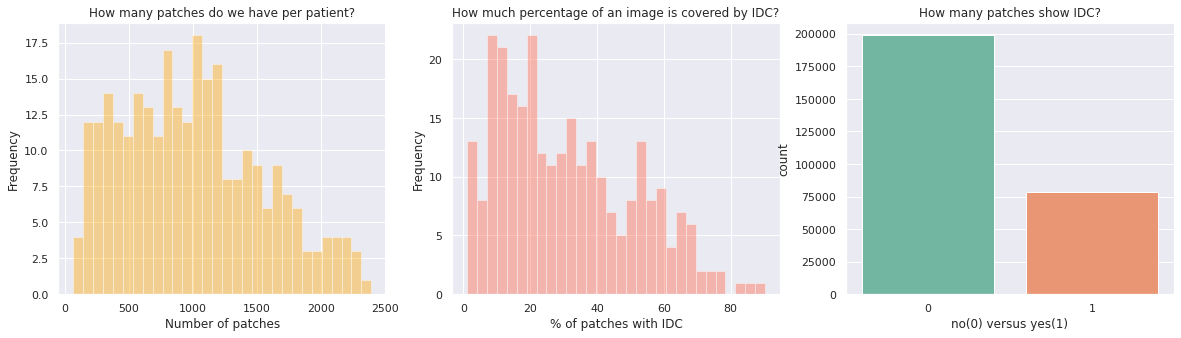

In [49]:
#Plotting the distribution of number of patches per patient
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency")
ax[0].set_title("How many patches do we have per patient?")

#Plotting the distribution of IDC percentage per patient
sns.distplot(cancer_perc.loc[:,"1"]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC")

#Plotting the count of patches with IDC and without IDC
sns.countplot(data.target, palette="Set2", ax=ax[2])
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?")
plt.show()